In [1]:
# !pip install numpy pandas matplotlib seaborn scipy statsmodels ipyleaflet

In [46]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from ipyleaflet import Map, Marker, MarkerCluster, AwesomeIcon

In [122]:
df = pd.read_csv('datasets/mta_1706.csv', error_bad_lines=False, low_memory=False, warn_bad_lines=False)

In [95]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Unnamed: 17
0,01-06-2017 00:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76,01-06-2017 00:03,24:06:14,NaN
1,01-06-2017 00:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62,01-06-2017 00:03,23:58:02,NaN
2,01-06-2017 00:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5,01-06-2017 00:03,24:00:53,NaN
3,01-06-2017 00:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267,01-06-2017 00:04,24:03:00,NaN
4,01-06-2017 00:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11,01-06-2017 00:03,23:59:38,NaN


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
RecordedAtTime               1048575 non-null object
DirectionRef                 1048575 non-null int64
PublishedLineName            1048575 non-null object
OriginName                   1040112 non-null object
OriginLat                    1040112 non-null float64
OriginLong                   1040112 non-null float64
DestinationName              1048575 non-null object
DestinationLat               1047329 non-null float64
DestinationLong              1047329 non-null float64
VehicleRef                   1048575 non-null object
VehicleLocation.Latitude     1048575 non-null float64
VehicleLocation.Longitude    1048575 non-null float64
NextStopPointName            1047439 non-null object
ArrivalProximityText         1047439 non-null object
DistanceFromStop             1047439 non-null object
ExpectedArrivalTime          931342 non-null object
ScheduledArrivalTime         102290



---



**Nominal or Categorical Datatype Example**

In [97]:
df.DirectionRef.unique()

array([0, 1], dtype=int64)

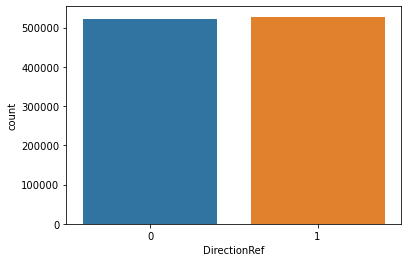

In [98]:
sns.countplot(x='DirectionRef', data=df)
plt.show()



---



**Measures of Central Tendency**

**Mean** of every numeric column(interval and ratio type data) present in the dataset

In [99]:
colMeans = df.drop('DirectionRef', axis=1).mean(axis=0, numeric_only=True)
print(colMeans)

OriginLat                    40.729366
OriginLong                  -73.931039
DestinationLat               40.728410
DestinationLong             -73.931583
VehicleLocation.Latitude     40.728354
VehicleLocation.Longitude   -73.930704
dtype: float64




---



**Median** of every numeric column(interval and ratio type data) present in the dataset

In [100]:
colMedians = df.drop('DirectionRef', axis=1).median(axis=0, numeric_only=True)
print(colMedians)

OriginLat                    40.715233
OriginLong                  -73.932449
DestinationLat               40.713356
DestinationLong             -73.932266
VehicleLocation.Latitude     40.722418
VehicleLocation.Longitude   -73.936326
dtype: float64




---



**Using Mean and Median**

To find the location which is equidistant from all the bus stops

In [101]:
from math import cos, sin, radians, atan2, sqrt, degrees, pi

pos = pd.DataFrame()

pos["Lat"] = np.hstack((df.OriginLat.dropna(), df.DestinationLat.dropna()))
pos["Lat"] = pos.Lat.apply(radians)

pos["Lon"] = np.hstack((df.OriginLong.dropna(), df.DestinationLong.dropna()))
pos["Lon"] = pos.Lon.apply(radians)

pos = pos.drop_duplicates()

pos["X"] = np.vectorize(lambda lat, lon: cos(lat)*cos(lon))(pos["Lat"], pos["Lon"])
pos["Y"] = np.vectorize(lambda lat, lon: cos(lat)*sin(lon))(pos["Lat"], pos["Lon"])
pos["Z"] = np.vectorize(sin)(pos["Lat"])

x = pos.X.mean() # pos.X.median()
y = pos.Y.mean() # pos.Y.median()
z = pos.Z.mean() # pos.Z.median()

Center_Lon = atan2(y, x)
Hyp = sqrt(x*x + y*y)
Center_Lat = atan2(z, Hyp)

print(f"Location Equidistant from all bus stops: {degrees(Center_Lat)} N, {-1*degrees(Center_Lon)} W")

Location Equidistant from all bus stops: 40.7178038962956 N, 73.9382220213454 W


The above location remains the same for both **mean** and **median** values



---



To locate the above found location on the map

In [102]:
center = (degrees(Center_Lat),degrees(Center_Lon))

m = Map(center=center, zoom=10)

icon1 = AwesomeIcon(
    name='bus',
    marker_color='red',
    icon_color='white',
    spin=False
)
marker = Marker(location=center, draggable=False, icon=icon1)


icon2 = AwesomeIcon(
    name='bus',
    marker_color='green',
    icon_color='white',
    spin=False
)

markers=list()
markers = ( Marker(location=(degrees(i[0]), degrees(i[1])), draggable=False, icon=icon2) for i in np.array(pos) )

marker_cluster = MarkerCluster( markers=tuple(markers) )

m.add_layer(marker)
m.add_layer(marker_cluster)

display(m)

Map(center=[40.7178038962956, -73.9382220213454], controls=(ZoomControl(options=['position', 'zoom_in_text', '…



---



**Mode** of every column present in the dataset(Nominal, interval and ratio type data)

In [103]:
colModes = df.mode(axis=0)
colModes.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Unnamed: 17
0,05-06-2017 08:00,1.0,B6,E 126 ST/2 AV,40.704906,-73.793304,WASHINGTON HTS GW BRIDGE,40.704933,-73.79332,NYCT_5852,40.714687,-73.831286,W 181 ST/AMSTERDAM AV,approaching,0,02-06-2017 07:46,08:17:00,08:47:50
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:46:08
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17:07:08




---



**Using Mode**

To find Common Initial(origin) and Final(destination) Stops with respect to directionRef(0 or 1).

In [104]:
origins = [
    df[df.DirectionRef==i]['OriginName'].value_counts().idxmax() 
    for i in df.DirectionRef.unique()
]
print(f"Common Origins:\n\tDir-0: {origins[0]}\n\tDir-1: {origins[1]}\n")

destinations = [
    df[df.DirectionRef==i]['DestinationName'].value_counts().idxmax() 
    for i in df.DirectionRef.unique()
]
print(f"Common Destinations:\n\tDir-0: {destinations[0]}\n\tDir-1: {destinations[1]}\n")

Common Origins:
	Dir-0: MERRICK BL/ARCHER AV
	Dir-1: E 126 ST/2 AV

Common Destinations:
	Dir-0: ST GEORGE FERRY
	Dir-1: WASHINGTON HTS GW BRIDGE





---



To find the most frequent paths from those Initial Stops(origins)

In [105]:
paths_from_origins = list( map( lambda x : 
                               [ 
                                   x,
                                   df[ df.OriginName == x ][ "DestinationName" ].value_counts().idxmax(),
                                   df[ df.OriginName == x ][ "DestinationName" ].value_counts()[0]
                               ],
                               origins
                              )
                         )
print("Most Common Paths from Common Origins:\n")
k=0
for i in paths_from_origins:
    print("\tDirection Reference:", k)
    k+=1
    print("\tFrom:", i[0])
    print("\tTo:", i[1])
    print("\tNo of Trips:", i[2],"\n")

Most Common Paths from Common Origins:

	Direction Reference: 0
	From: MERRICK BL/ARCHER AV
	To: SELECT BUS BRONX ZOO via MAIN ST
	No of Trips: 6303 

	Direction Reference: 1
	From: E 126 ST/2 AV
	To: SELECT BUS SERVICE SOUTH FERRY via 2 AV
	No of Trips: 7646 





---



To find the most frequent paths to those Final Stops(destinations)

In [106]:
paths_to_destinations = list( map( lambda x : 
                               [ 
                                   x,
                                   df[ df.DestinationName == x ][ "OriginName" ].value_counts().idxmax(),
                                   df[ df.DestinationName == x ][ "OriginName" ].value_counts()[0]
                               ],
                               destinations
                              )
                         )

print("\nMost Common Paths to Common Destination:\n")
k=0
for i in paths_to_destinations:
    print("\tDirection Reference:", k)
    k+=1
    print("\tFrom:", i[0])
    print("\tTo:", i[1])
    print("\tNo of Trips:", i[2],"\n")


Most Common Paths to Common Destination:

	Direction Reference: 0
	From: ST GEORGE FERRY
	To: YUKON AV/KMART DWY
	No of Trips: 3498 

	Direction Reference: 1
	From: WASHINGTON HTS GW BRIDGE
	To: RANDALL AV/OLMSTEAD AV
	No of Trips: 5215 





---



To find the number of buses from the above initial stops to the final stops

In [107]:
ini_stop_0 = df[df["DirectionRef"]==0]['OriginName'].mode().get(0)
ini_stop_1 = df[df["DirectionRef"]==1]['OriginName'].mode().get(0)
fin_stop_1 = df[df["DirectionRef"]==1]['DestinationName'].mode().get(0)
fin_stop_0 = df[df["DirectionRef"]==0]['DestinationName'].mode().get(0)

The most frequent path with DirectionRef = 0

In [108]:
(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0].mode())[["OriginName", "DestinationName"]]

C:\Users\Anurag\AppData\Local\conda\conda\envs\apidb\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OriginName,DestinationName
0,MERRICK BL/ARCHER AV,SELECT BUS BRONX ZOO via MAIN ST


The most frequent path with DirectionRef = 1

In [109]:
(df[df["DirectionRef"]==1][df['OriginName']==ini_stop_1].mode())[["OriginName", "DestinationName"]]

C:\Users\Anurag\AppData\Local\conda\conda\envs\apidb\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OriginName,DestinationName
0,E 126 ST/2 AV,SELECT BUS SERVICE SOUTH FERRY via 2 AV


To find the number of buses for the above paths

In [110]:
print(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0][["OriginName", "DestinationName"]][df.DestinationName==fin_stop_0].count(),"\n")
print(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0][["OriginName", "DestinationName"]][df.DestinationName==fin_stop_1].count())

C:\Users\Anurag\AppData\Local\conda\conda\envs\apidb\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


OriginName         0
DestinationName    0
dtype: int64 

OriginName         0
DestinationName    0
dtype: int64


C:\Users\Anurag\AppData\Local\conda\conda\envs\apidb\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


We find that there are no buses directly from those most frequent initial to final stops



---



From the above results, we also find that the central tendency measures(mean, median and mode) are the same for all the numeric columns(interval type data) except for the DistanceFromStop column(ratio type data)



---



**Distribution Type**

To identify the distribution type of data using visualizations like histograms, box-plot, kernel density estimation(kdeplot) and Quantile-Quantile(qqplot).



*   Origin Latitude column


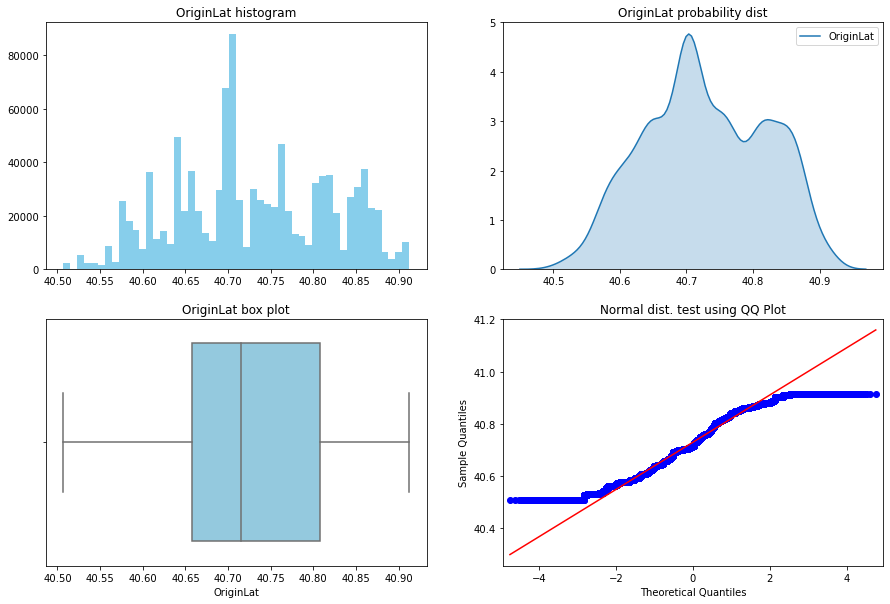

In [111]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['OriginLat'].dropna(), bins=50, color="skyblue")
a[0][0].set_title('OriginLat histogram')

sns.kdeplot(df['OriginLat'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('OriginLat probability dist')

sns.boxplot(x=df['OriginLat'].dropna(), ax=a[1][0], color="skyblue")
a[1][0].set_title('OriginLat box plot')

qqplot(df['OriginLat'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Origin Longitude column



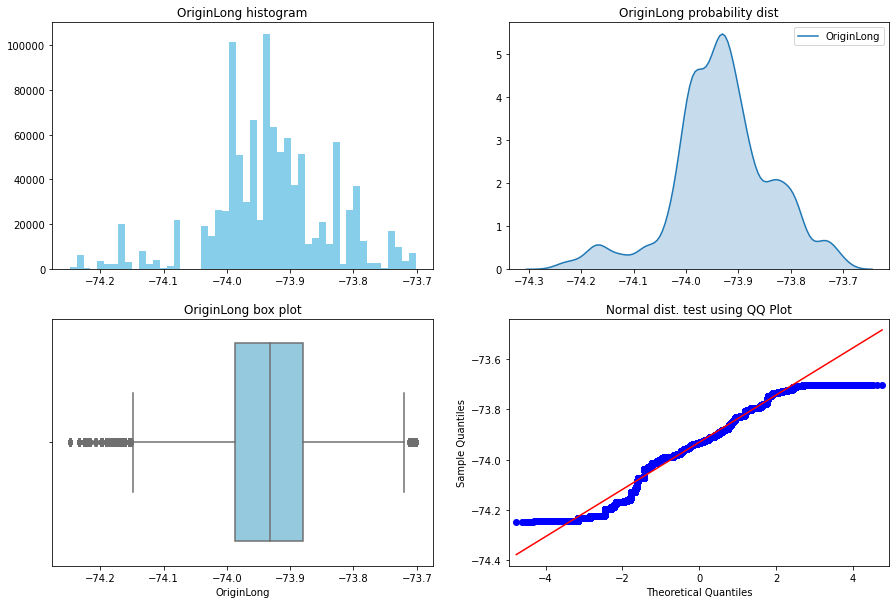

In [112]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['OriginLong'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('OriginLong histogram')

sns.kdeplot(df['OriginLong'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('OriginLong probability dist')

sns.boxplot(x=df['OriginLong'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('OriginLong box plot')

qqplot(df['OriginLong'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Destination Latitude column



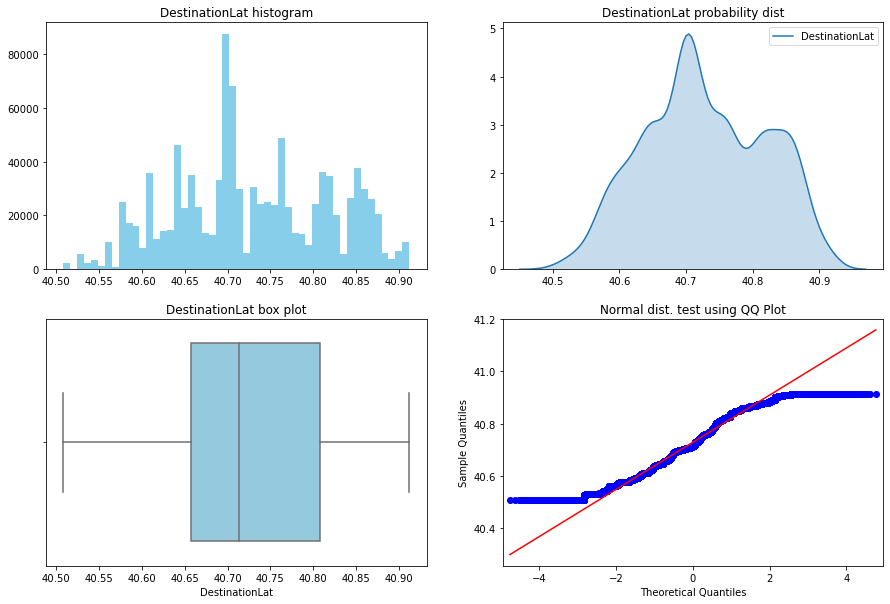

In [113]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['DestinationLat'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('DestinationLat histogram')

sns.kdeplot(df['DestinationLat'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('DestinationLat probability dist')

sns.boxplot(x=df['DestinationLat'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('DestinationLat box plot')

qqplot(df['DestinationLat'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()

*   Destination Longitude column data



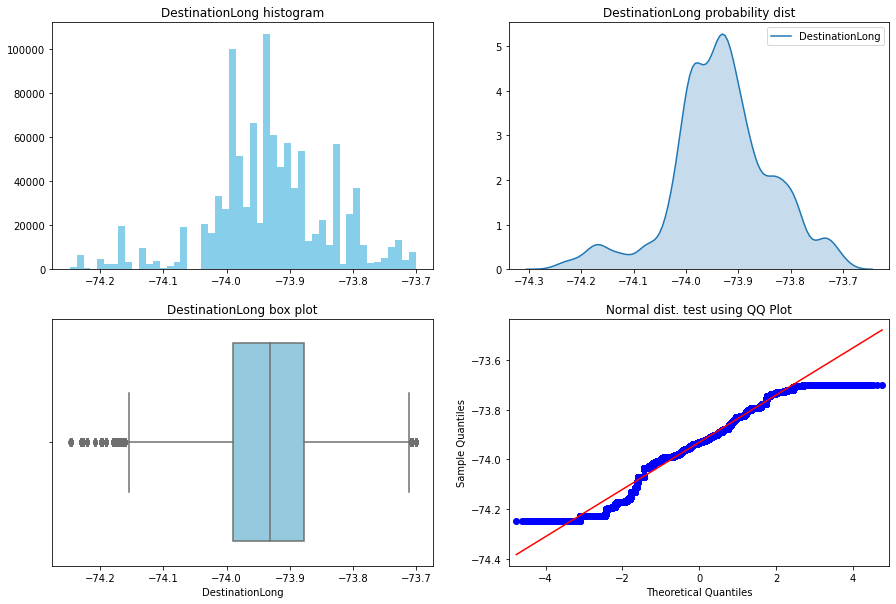

In [114]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['DestinationLong'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('DestinationLong histogram')

sns.kdeplot(df['DestinationLong'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('DestinationLong probability dist')

sns.boxplot(x=df['DestinationLong'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('DestinationLong box plot')

qqplot(df['DestinationLong'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Vehicle Location Latitude column





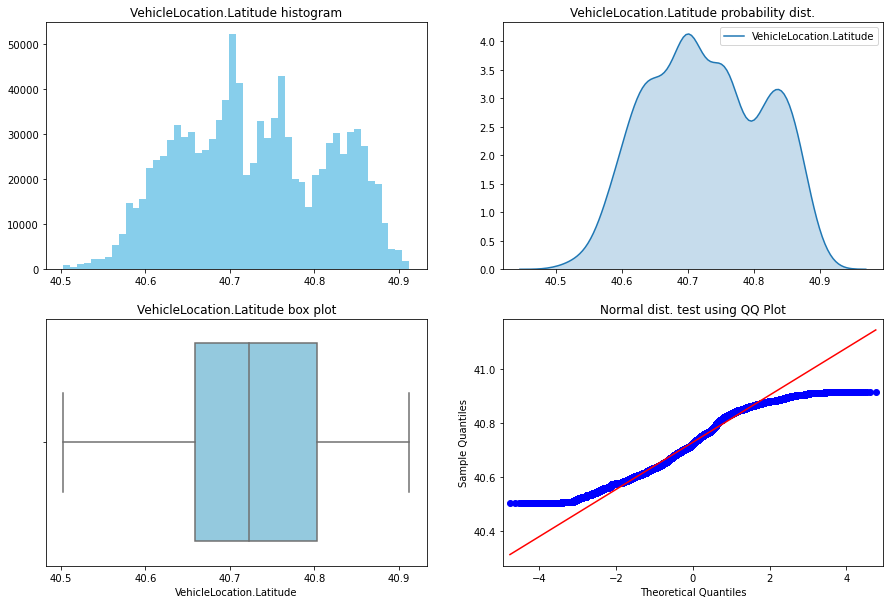

In [115]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['VehicleLocation.Latitude'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('VehicleLocation.Latitude histogram')

sns.kdeplot(df['VehicleLocation.Latitude'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('VehicleLocation.Latitude probability dist.')

sns.boxplot(x=df['VehicleLocation.Latitude'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('VehicleLocation.Latitude box plot')

qqplot(df['VehicleLocation.Latitude'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Vehicle Location Longitude column



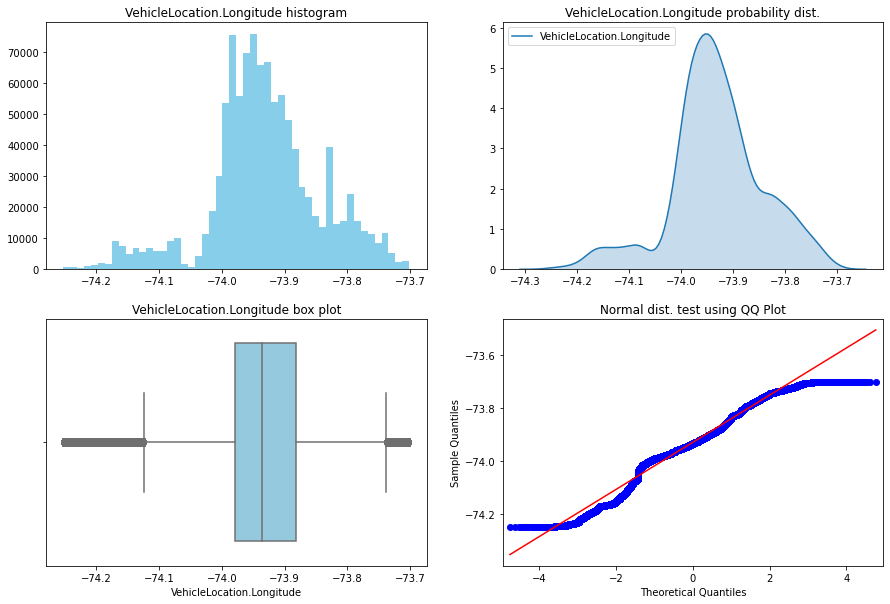

In [116]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['VehicleLocation.Longitude'].dropna(), bins=50, color='skyblue')
a[0][0].set_title('VehicleLocation.Longitude histogram')

sns.kdeplot(df['VehicleLocation.Longitude'].dropna(), bw=0.019, shade='blue', ax=a[0][1])
a[0][1].set_title('VehicleLocation.Longitude probability dist.')

sns.boxplot(x=df['VehicleLocation.Longitude'].dropna(), color='skyblue', ax=a[1][0])
a[1][0].set_title('VehicleLocation.Longitude box plot')

qqplot(df['VehicleLocation.Longitude'].dropna(), line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()

The above plots show that, the data follows normal distribution although there is a slight deviation from the actual distribution owing to the presence of certain outliers and the fact that no real time data can be perfect. Adding to the above observations we've also pointed that the central tendency measures are all equal which is usually the case when the data follows a normal distribution.



---





*   Distance From Stop column



In [125]:
# fig, a = plt.subplots(1, 2, figsize = (15, 5))

# a[0].hist(df['DistanceFromStop'].dropna(), bins=50)
# a[0].set_title('DistanceFromStop histogram')

# sns.kdeplot(df['DistanceFromStop'].dropna(), bw=0.019, shade='blue', ax=a[1])
# a[1].set_title('DistanceFromStop probability dist.')

# plt.show()

The above plots show that DistanceFromStop follows an exponential distribution because the number of buses reaching the intended stop grows exponentially.



---

